# Segmentation

## Set-up:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import itertools
import random
from sklearn.cluster import KMeans

## Part (A): Product affinity based segmentation

### Question 1:

To obtain characteristics of the affinity based segments for all products (similar to our product optimization work), we first need to derive four critical inputs: <br>
- 1) Description of candidate product and incumbent products
- 2) Preference parameters
- 3) Cost structure and dollar values for each price level
- 4) "c" value for logit probability formula

In addition to the four critical inputs, let's first load in our demographic data into a dataframe.

In [2]:
xl_file_dem = pd.ExcelFile('demographics-full.xlsx')
df_dem = xl_file_dem.parse("demographics-full")
del df_dem['id']
df_dem

,income,age,sports,gradschl
0,63,46,0,0
1,65,48,0,0
2,38,37,0,0
3,77,58,1,1
4,44,41,0,0
...,...,...,...,...
306,44,40,0,0
307,67,51,1,1
308,56,43,1,0
309,39,39,0,0


Let's first derive critical input 1 (*candidate and incumbent products*) below.

In [3]:
df_1 = pd.DataFrame(np.array([[1, 2, 1], [3, 2, 3], [2, 2, 2],[3, 2, 3],[3, 2, 3],[1, 2, 3]]), columns=['Prod1', 'Prod2', 'Prod3'], index=['Pr', 'In', 'Cp', 'Cl', 'Cn', 'Br'])

df_1

,Prod1,Prod2,Prod3
Pr,1,2,1
In,3,2,3
Cp,2,2,2
Cl,3,2,3
Cn,3,2,3
Br,1,2,3


Let's derive critical input 2 (*preference parameters*) next.

In [4]:
xl_file = pd.ExcelFile('mugs-preference-parameters-full.xlsx')
df_2 = xl_file.parse("mugs-full")
df_2

,Cust,pPr30,pPr10,pPr05,pIn0.5,pIn1,pIn3,pCp12,pCp20,pCp32,...,pCnLk,pBrA,pBrB,pBrC,IPr,Iin,ICp,ICl,Icn,IBr
0,1,1,3,7,1,3,7,1,7,6,...,7,7,5,1,5,8,32,7,34,14
1,2,1,6,7,1,4,7,1,7,6,...,7,7,5,1,6,3,17,10,51,15
2,3,1,6,7,1,4,7,7,4,1,...,7,1,3,7,55,5,5,8,16,9
3,4,1,6,7,1,4,7,7,1,3,...,7,7,1,5,12,9,3,40,20,16
4,5,1,4,7,1,4,7,1,7,2,...,7,3,1,7,56,6,19,9,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,307,1,3,7,1,6,7,1,7,6,...,7,4,1,7,54,13,6,10,7,10
307,308,1,3,7,1,6,7,1,7,6,...,7,7,1,4,8,24,4,39,15,11
308,309,1,6,7,1,5,7,1,7,3,...,7,7,3,1,12,34,16,14,13,11
309,310,1,3,7,1,5,7,1,7,1,...,7,1,5,7,57,5,5,17,5,10


Furthermore, let's also derive a table containing only the importance levels for each attribute.

In [5]:
df_I = pd.DataFrame()

df_I['IPr'] = df_2[' IPr']
df_I['IIn'] = df_2['Iin']
df_I['ICp'] = df_2[' ICp']
df_I['ICl'] = df_2[' ICl']
df_I['ICn'] = df_2['Icn']
df_I['IBr'] = df_2[' IBr']

df_I

,IPr,IIn,ICp,ICl,ICn,IBr
0,5,8,32,7,34,14
1,6,3,17,10,51,15
2,55,5,5,8,16,9
3,12,9,3,40,20,16
4,56,6,19,9,0,11
...,...,...,...,...,...,...
306,54,13,6,10,7,10
307,8,24,4,39,15,11
308,12,34,16,14,13,11
309,57,5,5,17,5,10


Then we derive critical input 3 (*cost structure and price levels*) next.

In [6]:
df_prices = pd.DataFrame(np.array([[30], [10], [5]]), columns=['Prices'], index=["P1", "P2", "P3"])
df_costs = pd.DataFrame(np.array([[0.5], [1], [3], [1], [2.6], [2.8], [1], [2.2], [3.0], [0.5], [0.8], [1]]), columns=['Costs'], index=["T1", "T2", "T3", "Ca1", "Ca2", "Ca3", "Cl1", 'Cl2', "Cl3", "Co1", "Co2", "Co3"])

print(df_prices)
print(df_costs)

    Prices
P1      30
P2      10
P3       5
     Costs
T1     0.5
T2     1.0
T3     3.0
Ca1    1.0
Ca2    2.6
Ca3    2.8
Cl1    1.0
Cl2    2.2
Cl3    3.0
Co1    0.5
Co2    0.8
Co3    1.0


Finally, we derive our critical input 4 (*c value*) which we have already computed as 0.0139.

In [7]:
c_value = 0.0139

Now that we have our four critical inputs, let's first compute the product of importance and preference level for each attribute level.

In [8]:
df_Ip = pd.DataFrame()

# Price attribute
for i in range(1, 4):
    df_Ip['IpPr' + str(i)] = df_2.iloc[:, i] * df_2[' IPr']
    
# Time attribute
for i in range(1, 4):
    df_Ip['IpIn' + str(i)] = df_2.iloc[:, i+3] * df_2['Iin']
    
# Capacity attribute
for i in range(1, 4):
    df_Ip['IpCp' + str(i)] = df_2.iloc[:, i+6] * df_2[' ICp']
    
# Cleanability attribute
for i in range(1, 4):
    df_Ip['IpCl' + str(i)] = df_2.iloc[:, i+9] * df_2[' ICl']
    
# Containment attribute
for i in range(1, 4):
    df_Ip['IpCn' + str(i)] = df_2.iloc[:, i+12] * df_2['Icn']
    
# Brand attribute
for i in range(1, 4):
    df_Ip['IpBr' + str(i)] = df_2.iloc[:, i+15] * df_2[' IBr']
    
df_Ip

,IpPr1,IpPr2,IpPr3,IpIn1,IpIn2,IpIn3,IpCp1,IpCp2,IpCp3,IpCl1,IpCl2,IpCl3,IpCn1,IpCn2,IpCn3,IpBr1,IpBr2,IpBr3
0,5,15,35,8,24,56,32,224,192,7,14,49,34,170,238,98,70,14
1,6,36,42,3,12,21,17,119,102,10,60,70,51,357,357,105,75,15
2,55,330,385,5,20,35,35,20,5,8,24,56,16,80,112,9,27,63
3,12,72,84,9,36,63,21,3,9,40,200,280,20,100,140,112,16,80
4,56,224,392,6,24,42,19,133,38,9,27,63,0,0,0,33,11,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,54,162,378,13,78,91,6,42,36,10,70,70,7,35,49,40,10,70
307,8,24,56,24,144,168,4,28,24,39,234,273,15,30,105,77,11,44
308,12,72,84,34,170,238,16,112,48,14,28,98,13,39,91,77,33,11
309,57,171,399,5,25,35,5,35,5,17,68,119,5,20,35,10,50,70


Now, let's compute the utility for each product. First, we need to create a dummy variable matrix based on the attribute levels from our critical input 1 (candidate and incumbent products).

In [9]:
# Initialize dummy variable matrix dataframe
dummy = np.zeros(shape=(18,3))
df_dummy = pd.DataFrame(dummy, columns = ['Prod1','Prod2','Prod3'])

# Create dummy variable vectors for each product separately
prod_1 = [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]
prod_2 = [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
prod_3 = [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]

df_dummy['Prod1'] = prod_1
df_dummy['Prod2'] = prod_2
df_dummy['Prod3'] = prod_3

df_dummy

,Prod1,Prod2,Prod3
0,1,0,1
1,0,1,0
2,0,0,0
3,0,0,0
4,0,1,0
5,1,0,1
6,0,0,0
7,1,1,1
8,0,0,0
9,0,0,0


Now, let's find the utilities of each product by doing matrix multiplication of the dummy variable matrix and the attribute level matrix. After finding utilities, we multiply by our "c" value and then exponentiate. We can then find the sum of the exponentials which we use to divide each exponential and get the purchase probability for each product.

In [10]:
# Calculate utilities multiplied by our "c" value and then exponentiated
utility = np.dot(df_Ip,df_dummy)
c_utility = np.multiply(utility,c_value)
exp_c_u = np.exp(c_utility)

# Use a for loop to find the sum of exponentiated utility values
sum_exp = np.zeros(shape=(311,1)) 

for i in range(len(sum_exp)):
    for j in range(3):
        sum_exp[i] += exp_c_u[i][j]

# Use a for loop to get purchase probabilities and then compute average probabilities
purch_prob = np.zeros(shape=(311,3))

for i in range(len(sum_exp)):
    for j in range(3):
        purch_prob[i][j] = exp_c_u[i][j] / sum_exp[i]

The following array gives us the purchase probabilities for Product 3 (our candidate) and will allow us to begin calculating the descriptor characteristics.

In [11]:
prob_3 = purch_prob[:,2]
prob_3

array([0.2175092 , 0.13933904, 0.09331564, 0.37274915, 0.28642993,
       0.68362376, 0.07594488, 0.14431071, 0.20663369, 0.03947223,
       0.59450137, 0.21483861, 0.08524137, 0.1952255 , 0.32669898,
       0.26878347, 0.5315812 , 0.1062555 , 0.19744434, 0.07896128,
       0.05390901, 0.0501094 , 0.36764128, 0.02794051, 0.14057827,
       0.28022199, 0.3330232 , 0.35760893, 0.04144507, 0.26623231,
       0.24491984, 0.36246031, 0.12980647, 0.37279334, 0.27542638,
       0.32761145, 0.14993978, 0.23229391, 0.19417094, 0.19744434,
       0.16835499, 0.31523079, 0.02763154, 0.28549419, 0.21873336,
       0.2739675 , 0.09952833, 0.33201721, 0.4091017 , 0.46314171,
       0.08267978, 0.17994245, 0.32305781, 0.10038397, 0.33845648,
       0.68657104, 0.27459556, 0.16991342, 0.2593646 , 0.23563082,
       0.14775796, 0.12483494, 0.21368182, 0.13391921, 0.58217241,
       0.39424411, 0.2372946 , 0.1860927 , 0.35771249, 0.20811881,
       0.12417921, 0.56206315, 0.38417068, 0.36574346, 0.34783

In addition, we can derive a sum of the probabilities for Product 3 below which will be useful in our calculations.

In [12]:
sum_3 = np.sum(prob_3)
sum_3

80.49934097829947

Let's first report the characteristics for our importance descriptors.

In [13]:
imp_3 = []

for i in range(6):
    importance = np.dot(df_I.iloc[:,i], prob_3) / sum_3
    imp_3.append(importance)

df_I3 = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr'])
df_I3.loc[len(df_I3.index)] = imp_3

print(df_I3.to_string(index=False))

      IPr       Iin       ICp       ICl       ICn       IBr
25.956316 11.138901 12.198223 21.131582 16.648434 12.966477


Next, let's report our characteristics for the importance x preference level descriptors.

In [14]:
IxP_3 = []

for i in range(18):
    IxP = np.dot(df_Ip.iloc[:,i], prob_3) / sum_3
    IxP_3.append(IxP)

df_IxP3 = pd.DataFrame(columns = ['I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC'])
df_IxP3.loc[len(df_IxP3.index)] = IxP_3

df_IxP3.T

,0
I*pPr30,25.956316
I*pPr10,130.129136
I*pPr05,181.694209
I*pIn0.5,11.138901
I*pIn1,45.237124
I*pIn3,77.972310
I*pCp12,44.345185
I*pCp20,68.433621
I*pCp32,40.626979
I*pClD,21.131582


Finally, let's report our characteristics for the demographics descriptors.

In [15]:
dem_3 = []

for i in range(4):
    demo = np.dot(df_dem.iloc[:,i], prob_3) / sum_3
    dem_3.append(demo)

df_dem3 = pd.DataFrame(columns = ['income','age','sports','gradschool'])
df_dem3.loc[len(df_I3.index)] = dem_3

print(df_dem3.to_string(index=False))

   income       age   sports  gradschool
57.744594 46.474165 0.448355    0.448449


### Question 2:

Let's now compute and report the characteristics of the affinity based segments for Products 1 and 2. First, let's start with getting the purchase probabilities and sum of purchase probabilities for both products.

In [16]:
prob_1 = purch_prob[:,0]
prob_2 = purch_prob[:,1]

sum_1 = np.sum(prob_1)
sum_2 = np.sum(prob_2)

#### Product 1 characteristics:

In [17]:
imp_1 = []

for i in range(6):
    importance = np.dot(df_I.iloc[:,i], prob_1) / sum_1
    imp_1.append(importance)

df_I1 = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr'])
df_I1.loc[len(df_I1.index)] = imp_1

print(df_I1.to_string(index=False))

      IPr       Iin       ICp       ICl       ICn       IBr
18.042101 13.357271 16.362322 18.474938 20.659395 13.117021


In [18]:
IxP_1 = []

for i in range(18):
    IxP = np.dot(df_Ip.iloc[:,i], prob_1) / sum_1
    IxP_1.append(IxP)

df_IxP1 = pd.DataFrame(columns = ['I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC'])
df_IxP1.loc[len(df_IxP3.index)] = IxP_1

df_IxP1.T

,1
I*pPr30,18.042101
I*pPr10,92.440598
I*pPr05,126.294705
I*pIn0.5,13.357271
I*pIn1,56.655584
I*pIn3,93.500900
I*pCp12,60.202617
I*pCp20,92.902883
I*pCp32,54.308334
I*pClD,18.474938


In [19]:
dem_1 = []

for i in range(4):
    demo = np.dot(df_dem.iloc[:,i], prob_1) / sum_1
    dem_1.append(demo)

df_dem1 = pd.DataFrame(columns = ['income','age','sports','gradschool'])
df_dem1.loc[len(df_I1.index)] = dem_1

print(df_dem1.to_string(index=False))

   income       age   sports  gradschool
60.168849 46.711944 0.470805     0.35962


#### Product 2 characteristics:

In [20]:
imp_2 = []

for i in range(6):
    importance = np.dot(df_I.iloc[:,i], prob_2) / sum_2
    imp_2.append(importance)

df_I2 = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr'])
df_I2.loc[len(df_I2.index)] = imp_2

print(df_I2.to_string(index=False))

      IPr      Iin       ICp      ICl       ICn       IBr
38.985193 8.963154 12.162438 14.56508 12.399438 12.891366


In [21]:
IxP_2 = []

for i in range(18):
    IxP = np.dot(df_Ip.iloc[:,i], prob_2) / sum_2
    IxP_2.append(IxP)

df_IxP2 = pd.DataFrame(columns = ['I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC'])
df_IxP2.loc[len(df_IxP2.index)] = IxP_2

df_IxP2.T

,0
I*pPr30,38.985193
I*pPr10,220.582421
I*pPr05,272.896354
I*pIn0.5,8.963154
I*pIn1,38.657456
I*pIn3,62.742081
I*pCp12,44.606073
I*pCp20,68.052498
I*pCp32,41.513944
I*pClD,14.565080


In [22]:
dem_2 = []

for i in range(4):
    demo = np.dot(df_dem.iloc[:,i], prob_2) / sum_2
    dem_2.append(demo)

df_dem2 = pd.DataFrame(columns = ['income','age','sports','gradschool'])
df_dem2.loc[len(df_I2.index)] = dem_2

print(df_dem2.to_string(index=False))

   income       age   sports  gradschool
49.634303 42.848971 0.168093    0.247873


Next, we compute the overall mean for each descriptor.

First, we do the overall mean for the importances.

In [23]:
mean_imp = []

for i in range(6):
    mean = df_I.iloc[:,i].mean()
    mean_imp.append(mean)

df_meanI = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr'])
df_meanI.loc[len(df_meanI.index)] = mean_imp

print(df_meanI.to_string(index=False))

      IPr      Iin       ICp       ICl       ICn       IBr
29.125402 10.88746 13.472669 17.475884 16.057878 12.980707


Next, are the overall means for the importance x preference levels.

In [24]:
mean_IxP = []

for i in range(18):
    mean = df_Ip.iloc[:,i].mean()
    mean_IxP.append(mean)

df_meanIP = pd.DataFrame(columns = ['I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC'])
df_meanIP.loc[len(df_meanIP.index)] = mean_IxP

df_meanIP.T

,0
I*pPr30,29.125402
I*pPr10,157.475884
I*pPr05,203.877814
I*pIn0.5,10.887460
I*pIn1,45.935691
I*pIn3,76.212219
I*pCp12,49.369775
I*pCp20,75.848875
I*pCp32,45.247588
I*pClD,17.475884


Last, we find the overall means for the demographic descriptors.

In [25]:
mean_dem = []

for i in range(4):
    mean = df_dem.iloc[:,i].mean()
    mean_dem.append(mean)

df_meanD = pd.DataFrame(columns = ['income','age','sports','gradschool'])
df_meanD.loc[len(df_meanD.index)] = mean_dem

print(df_meanD.to_string(index=False))

   income       age   sports  gradschool
54.996785 44.983923 0.334405    0.334405


Next, let's compute the log-lifts for all variables for the affinity based segment for each product.

First, let's start with computing log-lifts for our importance descriptors.

In [26]:
imp_frames = [df_I1, df_I2, df_I3]
log_imp = pd.concat(imp_frames, ignore_index=True)

for i in range(6):
    for j in range(3):
        log_imp.iloc[j][i] = math.log(log_imp.iloc[j][i] / df_meanI.iloc[0][i], 10)

log_imp.rename(index={0: 'seg1', 1: 'seg2', 2: 'seg3'})

,IPr,Iin,ICp,ICl,ICn,IBr
seg1,-0.207985,0.088791,0.084391,0.024144,0.109429,0.004537
seg2,0.126628,-0.084466,-0.044433,-0.079126,-0.112286,-0.002999
seg3,-0.050029,0.009916,-0.043157,0.082493,0.015685,-0.000476


Next, we compute log-lifts for our importance x preference descriptors.

In [27]:
IP_frames = [df_IxP1, df_IxP2, df_IxP3]
log_IxP = pd.concat(IP_frames, ignore_index=True)

for i in range(18):
    for j in range(3):
        log_IxP.iloc[j][i] = math.log(log_IxP.iloc[j][i] / df_meanIP.iloc[0][i], 10)

log_IxP = log_IxP.rename(index={0: 'seg1', 1: 'seg2', 2: 'seg3'})
log_IxP.T

,seg1,seg2,seg3
I*pPr30,-0.207985,0.126628,-0.050029
I*pPr10,-0.231351,0.146357,-0.082840
I*pPr05,-0.207985,0.126628,-0.050029
I*pIn0.5,0.088791,-0.084466,0.009916
I*pIn1,0.091092,-0.074917,-0.006655
I*pIn3,0.088791,-0.084466,0.009916
I*pCp12,0.086154,-0.044067,-0.046615
I*pCp20,0.088080,-0.047105,-0.044680
I*pCp32,0.079271,-0.037401,-0.046781
I*pClD,0.024144,-0.079126,0.082493


Lastly, we compute log-lifts for our demographic descriptors.

In [28]:
dem_frames = [df_dem1, df_dem2, df_dem3]
log_dem = pd.concat(dem_frames, ignore_index=True)

for i in range(4):
    for j in range(3):
        log_dem.iloc[j][i] = math.log(log_dem.iloc[j][i] / df_meanD.iloc[0][i], 10)

log_dem.rename(index={0: 'seg1', 1: 'seg2', 2: 'seg3'})

,income,age,sports,gradschool
seg1,0.039034,0.016371,0.148568,0.031571
seg2,-0.044555,-0.021117,-0.298723,-0.130045
seg3,0.021174,0.014154,0.127349,0.127440


### Question 3:

**Segment 1:** This segment has a higher income on average, is generally more educated and much more likely to be active on a daily basis. They appreciate items of higher quality and don't mind paying more for those items that have better features. Therefore, they place significantly less emphasis on the price of the mug and care more about the features of the mug such as time insulation, capacity, and containment.

**Segment 2:** This segment has a lower income on average, and is much less active and educated compared to the average. Because they have a lower income on average and are slightly earlier on in their lives too, they care much more about the price of an item and less about the quality of the product. They would just prefer a mug at a good price and are very flexible on the time insulation, cleanability, and containment of the mug.

**Segment 3:** This segment is similar to segment 1 in terms of age and activity level, but is far more educated than average and has slightly less income. While price matters a little more compared to segment 1, they are still less price sensitive than average. The mug feature they care least about is the capacity but they place more importance on the cleanability of the mug.

## Part (B): Classical segmentation

### K-means cluster analysis set-up:

Before we compute characteristics of all segments, we first need to run a kmeans cluster analysis to determine how we should segment and construct our item archetypes. For our analysis, we will try different values of "k" from 2 to 10.

In [29]:
# Set k values
k_2 = 2
k_3 = 3
k_4 = 4
k_5 = 5
k_6 = 6
k_7 = 7
k_8 = 8
k_9 = 9
k_10 = 10

Let's also create an array containing data on the variables we will be using for this analysis.

In [30]:
X_df = pd.concat([df_I, df_Ip], axis=1)
X_var = X_df.to_numpy()
X_var

array([[  5,   8,  32, ...,  98,  70,  14],
       [  6,   3,  17, ..., 105,  75,  15],
       [ 55,   5,   5, ...,   9,  27,  63],
       ...,
       [ 12,  34,  16, ...,  77,  33,  11],
       [ 57,   5,   5, ...,  10,  50,  70],
       [ 20,  23,   2, ...,  80,  16, 112]], dtype=int64)

Now, let's run the kmeans cluster analysis for our first value of k.

**k=2**

In [31]:
random.seed(410014)

kmeansModel2 = KMeans(n_clusters=k_2, n_init=50, max_iter=100)
kmeansModel2.fit(X_var)
ss2 = (kmeansModel2.inertia_) / X_var.shape[0]

We can run the kmeans cluster analysis now for the rest of the k values.

**k=3**

In [32]:
random.seed(410014)

kmeansModel3 = KMeans(n_clusters=k_3, n_init=50, max_iter=100)
kmeansModel3.fit(X_var)
ss3 = (kmeansModel3.inertia_) / X_var.shape[0]

**k=4**

In [33]:
random.seed(410014)

kmeansModel4 = KMeans(n_clusters=k_4, n_init=50, max_iter=100)
kmeansModel4.fit(X_var)
ss4 = (kmeansModel4.inertia_) / X_var.shape[0]

**k=5**

In [34]:
random.seed(410014)

kmeansModel5 = KMeans(n_clusters=k_5, n_init=50, max_iter=100)
kmeansModel5.fit(X_var)
ss5 = (kmeansModel5.inertia_) / X_var.shape[0]

**k=6**

In [35]:
random.seed(410014)

kmeansModel6 = KMeans(n_clusters=k_6, n_init=50, max_iter=100)
kmeansModel6.fit(X_var)
ss6 = (kmeansModel6.inertia_) / X_var.shape[0]

**k=7**

In [36]:
random.seed(410014)

kmeansModel7 = KMeans(n_clusters=k_7, n_init=50, max_iter=100)
kmeansModel7.fit(X_var)
ss7 = (kmeansModel7.inertia_) / X_var.shape[0]

**k=8**

In [37]:
random.seed(410014)

kmeansModel8 = KMeans(n_clusters=k_8, n_init=50, max_iter=100)
kmeansModel8.fit(X_var)
ss8 = (kmeansModel8.inertia_) / X_var.shape[0]

**k=9**

In [38]:
random.seed(410014)

kmeansModel9 = KMeans(n_clusters=k_9, n_init=50, max_iter=100)
kmeansModel9.fit(X_var)
ss9 = (kmeansModel9.inertia_) / X_var.shape[0]

**k=10**

In [39]:
random.seed(410014)

kmeansModel10 = KMeans(n_clusters=k_10, n_init=50, max_iter=100)
kmeansModel10.fit(X_var)
ss10 = (kmeansModel10.inertia_) / X_var.shape[0]

Now that we have computed the average within-cluster sum of squares for each value of "k", let's create a plot with k from 2 to 10 on the x-axis and the average within-cluster sum of squares on the y-axis.

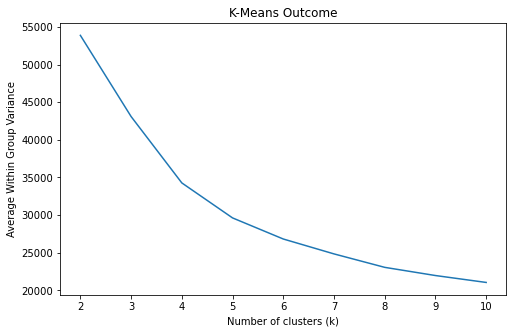

In [40]:
k_values = [k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10]
avg_ss = [ss2,ss3,ss4,ss5,ss6,ss7,ss8,ss9,ss10]
  
plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_ss)
plt.title('K-Means Outcome')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Within Group Variance')
plt.show()

Based on the plot above, it seems the best value of "k" to pick would be k=4 as further increases in the number of clusters does not significantly improve upon the average within group variance.

### Question 1:

Now that we have decided to use k=4 for our cluster analysis, let's lay out our segmentation basis set along with the segment ID that we will tag each customer with.

In [45]:
cluster_df = pd.concat([df_I, df_Ip, df_dem], axis=1)
cluster_df['impseg'] = kmeansModel4.labels_ + 1
cluster_df.index += 1

cluster_df

,IPr,IIn,ICp,ICl,ICn,IBr,IpPr1,IpPr2,IpPr3,IpIn1,...,IpCn2,IpCn3,IpBr1,IpBr2,IpBr3,income,age,sports,gradschl,impseg
1,5,8,32,7,34,14,5,15,35,8,...,170,238,98,70,14,63,46,0,0,1
2,6,3,17,10,51,15,6,36,42,3,...,357,357,105,75,15,65,48,0,0,1
3,55,5,5,8,16,9,55,330,385,5,...,80,112,9,27,63,38,37,0,0,3
4,12,9,3,40,20,16,12,72,84,9,...,100,140,112,16,80,77,58,1,1,4
5,56,6,19,9,0,11,56,224,392,6,...,0,0,33,11,77,44,41,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,54,13,6,10,7,10,54,162,378,13,...,35,49,40,10,70,44,40,0,0,3
308,8,24,4,39,15,11,8,24,56,24,...,30,105,77,11,44,67,51,1,1,4
309,12,34,16,14,13,11,12,72,84,34,...,39,91,77,33,11,56,43,1,0,2
310,57,5,5,17,5,10,57,171,399,5,...,20,35,10,50,70,39,39,0,0,3


Now, let's compute the characteristics of **segment 1**.

In [46]:
seg_1 = cluster_df[cluster_df["impseg"] == 1]

seg_1_mean = []

for i in range(28):
    mean = seg_1.iloc[:,i].mean()
    seg_1_mean.append(mean)

df_seg1 = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr','I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC','income','age','sports','gradschool'])
df_seg1.loc[len(df_seg1.index)] = seg_1_mean

df_seg1.rename(index={0: 'seg1'}).T

,seg1
IPr,12.733333
Iin,11.244444
ICp,9.333333
ICl,11.644444
ICn,41.644444
IBr,13.533333
I*pPr30,12.733333
I*pPr10,68.288889
I*pPr05,89.133333
I*pIn0.5,11.244444


Below are the characteristics for the rest of the segments.

**Segment 2**

In [47]:
seg_2 = cluster_df[cluster_df["impseg"] == 2]

seg_2_mean = []

for i in range(28):
    mean = seg_2.iloc[:,i].mean()
    seg_2_mean.append(mean)

df_seg2 = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr','I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC','income','age','sports','gradschool'])
df_seg2.loc[len(df_seg1.index)] = seg_2_mean

df_seg2.rename(index={1: 'seg2'}).T

,seg2
IPr,13.090909
Iin,16.981818
ICp,34.600000
ICl,11.109091
ICn,11.163636
IBr,13.018182
I*pPr30,13.090909
I*pPr10,66.690909
I*pPr05,91.636364
I*pIn0.5,16.981818


**Segment 3**

In [48]:
seg_3 = cluster_df[cluster_df["impseg"] == 3]

seg_3_mean = []

for i in range(28):
    mean = seg_3.iloc[:,i].mean()
    seg_3_mean.append(mean)

df_seg3 = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr','I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC','income','age','sports','gradschool'])
df_seg3.loc[len(df_seg3.index)] = seg_3_mean

df_seg3.rename(index={0: 'seg3'}).T

,seg3
IPr,45.702703
Iin,8.520270
ICp,8.831081
ICl,12.601351
ICn,11.479730
IBr,12.851351
I*pPr30,45.702703
I*pPr10,250.263514
I*pPr05,319.918919
I*pIn0.5,8.520270


**Segment 4**

In [49]:
seg_4 = cluster_df[cluster_df["impseg"] == 4]

seg_4_mean = []

for i in range(28):
    mean = seg_4.iloc[:,i].mean()
    seg_4_mean.append(mean)

df_seg4 = pd.DataFrame(columns = ['IPr','Iin','ICp','ICl','ICn','IBr','I*pPr30','I*pPr10','I*pPr05','I*pIn0.5','I*pIn1','I*pIn3','I*pCp12','I*pCp20','I*pCp32','I*pClD','I*pClF','I*pClE','I*pCnSl','I*pCnSp','I*pCnLk','I*pBrA','I*pBrB','I*pBrC','income','age','sports','gradschool'])
df_seg4.loc[len(df_seg4.index)] = seg_4_mean

df_seg4.rename(index={0: 'seg4'}).T

,seg4
IPr,15.888889
Iin,10.873016
ICp,8.888889
ICl,38.650794
ICn,12.809524
IBr,12.857143
I*pPr30,15.888889
I*pPr10,82.460317
I*pPr05,111.222222
I*pIn0.5,10.873016


## Question 2:

Now, we compute the log-lifts for all variables for all segments.

In [51]:
all_frames = [df_seg1, df_seg2, df_seg3, df_seg4]
cluster_means = pd.concat([df_meanI, df_meanIP, df_meanD], axis=1)
log_segs = pd.concat(all_frames, ignore_index=True)

for i in range(28):
    for j in range(4):
        log_segs.iloc[j][i] = math.log(log_segs.iloc[j][i] / cluster_means.iloc[0][i], 10)

log_segs.rename(index={0: 'seg1', 1: 'seg2', 2: 'seg3', 3: 'seg4'}).T

,seg1,seg2,seg3,seg4
IPr,-0.359330,-0.347302,0.195670,-0.263178
Iin,0.014011,0.193058,-0.106473,-0.000577
ICp,-0.159417,0.409622,-0.183440,-0.180606
ICl,-0.176320,-0.196761,-0.142022,0.344719
ICn,0.413869,-0.157882,-0.145756,-0.098155
IBr,0.018106,0.001252,-0.004350,-0.004154
I*pPr30,-0.359330,-0.347302,0.195670,-0.263178
I*pPr10,-0.362864,-0.373147,0.201183,-0.280969
I*pPr05,-0.359330,-0.347302,0.195670,-0.263178
I*pIn0.5,0.014011,0.193058,-0.106473,-0.000577


## Question 3:

**Segment 1:** This segment is much more active, has a higher income, and is less educated overall. Because of this, they place less importance on price and are more picky about the quality and features that a certain item has. Specifically with this segment, they want place a great deal of importance on the Containment capability of the mug. However, they care less about the capacity and cleanability of the mug.

**Segment 2:** This segment is much less educated on average, but more active than average. They also have slightly more income on average and are thus willing to pay more for an item as long as certain features are up to par. For the mug product, it's important that they get a mug with good time insulation and good capacity, but care less about the cleanability and containment of a mug.

**Segment 3:** This segment is much less active, has less income, and is less educated. Because they have less income, they place more importance on getting an affordable price and less about the quality or features of an item. Therefore, the mug must have a good price but all features such as time insulation, capacity, etc. are not nearly as important as the price.

**Segment 4:** This segment is much more active, much more educated, is older and has higher income. This segment is likely in the later stages of their life with children that are out of the household. Therefore, they are less price sensitive and more willing to pay for a product that fits well with their lifestyle. Considering they are more active, they'd want more time for themselves to be active and less with activities like cleaning. Therefore, the cleanability of the mug is most important to them, but place less immportance on features like capacity and containment.